In [2]:
#what this notebook does, writer name, runtime, details   

import json
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn import metrics
from sklearn.metrics import average_precision_score, accuracy_score

from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs, class_balance
from epilepsypcm.utils.outcome_params import engel_score

In [3]:
#Location
base_path = '/Users/david/Desktop/PCM_Data/' #modify for your file location


#Function to get a list of all dataframes for all positive patients, in the format [patient number, df]
df_list = get_df_list(base_path, "1")

#Code to loop through this list
#for i in range(len(df_list)):
#    print("Patient ID: ", df_list[i][0])
#    print("Patient Dataframe: ", df_list[i][1].head(3))
 
#Function to get the concatenated dataframe for all positive patients
## balance parameter can be changed to "None", "upsample", or "downsample"
all_positive_patients = concat_dfs(base_path, "1", balance = "None")

#print("Full Dataframe: ", all_positive_patients.head(3))

/Users/david/Documents/GitHub/epilepsypcm/epilepsypcm/utils/make_df.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outcome"][df["chNames"] == channel] = 1


In [4]:
from sklearn.model_selection import train_test_split

# drop certain columns and get X and Y
X = all_positive_patients.drop(['chNames','outcome','significant','flipped'], axis=1)
Y = all_positive_patients['outcome']

# run test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=100)
x_train, y_train = class_balance(x_train, y_train, balance = 'downsample')

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train[['n1Zscore','n2Zscore','p2Zscore','n1Latency','n2Latency','p2Latency']]=scaler.fit_transform(x_train[['n1Zscore','n2Zscore','p2Zscore','n1Latency','n2Latency','p2Latency']])
x_test[['n1Zscore','n2Zscore','p2Zscore','n1Latency','n2Latency','p2Latency']]=scaler.fit_transform(x_test[['n1Zscore','n2Zscore','p2Zscore','n1Latency','n2Latency','p2Latency']])
# absolute value of zscore
x_train = x_train.abs()
x_test = x_test.abs()

# Importing libraries to build the moddel
import statsmodels.api as sm

# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(x_train)), family = sm.families.Binomial())
res1 = logm1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                outcome   No. Observations:                 4236
Model:                            GLM   Df Residuals:                     4229
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2912.9
Date:                Tue, 14 Dec 2021   Deviance:                       5825.8
Time:                        13:24:50   Pearson chi2:                 4.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01094
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0787      0.062      1.272      0.203      -0.043       0.200
n1Zscore      -0.1061      0.051     -2.086      0.037      -0.206      -0.006
n2Zscore       0.0015      0.052      0.029      0.977      -0.100       0.103
p2Zscore      -0.1835      0.053     -3.462      0.001      -0.287      -0.080
n1Latency      0.0609      0.052      1.178      0.239      -0.040       0.162
n2Latency      0.0090      0.058      0.156      0.876      -0.104       0.123
p2Latency     -0.0174      0.055     -0.316      0.752      -0.126       0.091
==============================================================================
"""

Text(0.5, 1.0, 'PR Curve GLM')

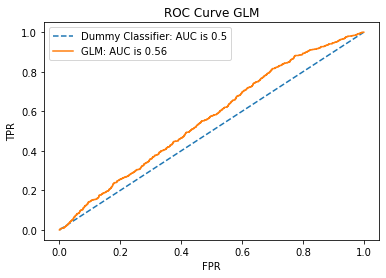

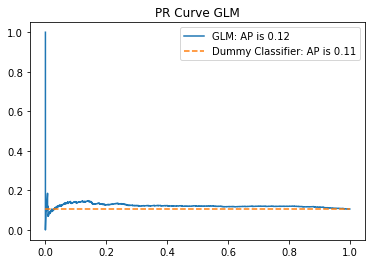

In [79]:
# all parameters test set
x_test_final = sm.add_constant(x_test)

y_test_pred = res1.predict(x_test_final)
y_test_pred_final = pd.DataFrame({'EZ':y_test.values, 'EZ_Prob':y_test_pred})
y_test_pred_final['NodeID'] = y_test.index

# find best probability
accuracy = []
for i in np.arange(0,1,0.0001):
    y_test_pred_final['predicted'] = y_test_pred_final.EZ_Prob.map(lambda x: 1 if x > i else 0)
    accuracy.append(metrics.accuracy_score(y_test_pred_final.EZ, y_test_pred_final.predicted))
best_pro_index = accuracy.index(max(accuracy))

# Creating new column 'predicted' 
y_test_pred_final['predicted'] = y_test_pred_final.EZ_Prob.map(lambda x: 1 if x > (best_pro_index/10000) else 0)

# print('Accuracy on the test set is',metrics.accuracy_score(y_test_pred_final.EZ, y_test_pred_final.predicted))

# ROC Curve and auc value for the test set

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
roc_auc = metrics.auc(fpr,tpr)
# print('AUC of the test set is', roc_auc)

# pr curve and average
precision,recall,threshold = metrics.precision_recall_curve(y_test, y_test_pred)
Ave_Prec = average_precision_score(y_test, y_test_pred, average='macro', pos_label=1, sample_weight=None)
# print('AP of the test set is', Ave_Prec)

# dummy classifier for pr curve 
y_pred_dummy = np.random.randint(0, 2, len(y_test))
pr_dummy = len(y_test[y_test==1]) / len(y_test)
# print('AP for the dummy classifier is',pr_dummy)

# plot ROC
plt.figure()
plt.plot([0,1],[0,1],linestyle = '--')
plt.plot(fpr,tpr)
plt.legend(['No Model: AUC is 0.5','GLM: AUC is {}'.format('%0.2f'%roc_auc)], loc = 'best')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve GLM')

# PR Curve and AP value for the test set
plt.figure()
plt.plot(recall,precision)
plt.plot([0, 1], [pr_dummy, pr_dummy], linestyle = '--')
plt.legend(['No Model: AP is {}'.format('%0.2f'%pr_dummy),'GLM: AP is {}'.format('%0.2f'%Ave_Prec)], loc = 'best')
plt.title('PR Curve GLM')

<AxesSubplot:>

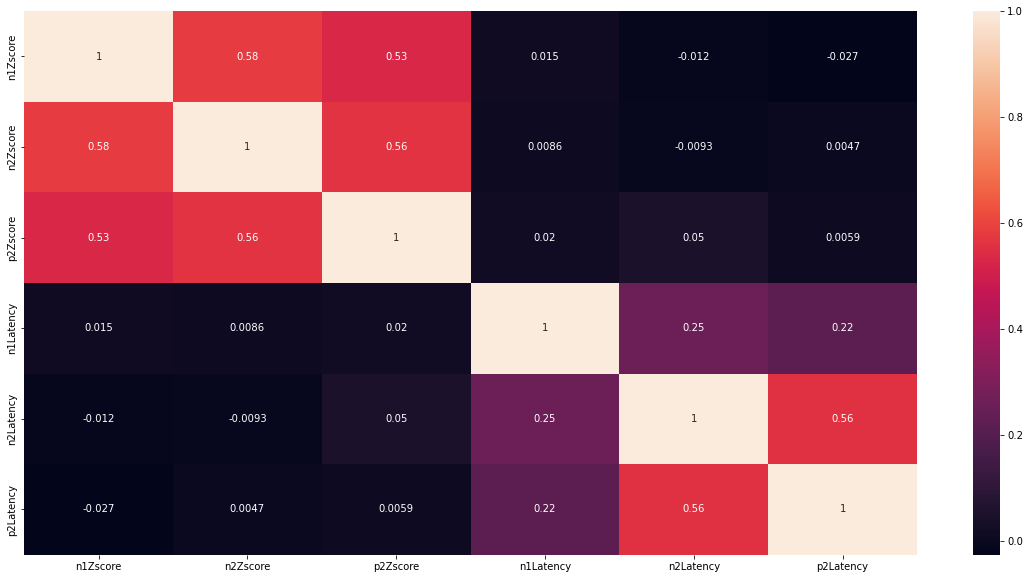

In [80]:
# Parameters corelated
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(x_train.corr(),annot = True)

In [5]:
# using RFE to find the best parameters

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.feature_selection import RFE
rfe = RFE(logreg)
rfe = rfe.fit(x_train, y_train)

list(zip(x_train.columns, rfe.support_, rfe.ranking_))

# Best parameters
col = x_train.columns[rfe.support_]

x_train_sm = sm.add_constant(x_train[col])
logm2 = sm.GLM(y_train,x_train_sm, family = sm.families.Binomial())
res2 = logm2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                outcome   No. Observations:                 4236
Model:                            GLM   Df Residuals:                     4232
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2912.9
Date:                Tue, 14 Dec 2021   Deviance:                       5825.9
Time:                        13:25:19   Pearson chi2:                 4.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01091
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0742      0.053      1.402      0.161      -0.030       0.178
n1Zscore      -0.1053      0.047     -2.254      0.024      -0.197      -0.014
p2Zscore      -0.1829      0.050     -3.667      0.000      -0.281      -0.085
n1Latency      0.0591      0.050      1.188      0.235      -0.038       0.157
==============================================================================
"""

Text(0.5, 1.0, 'PR Curve GLM')

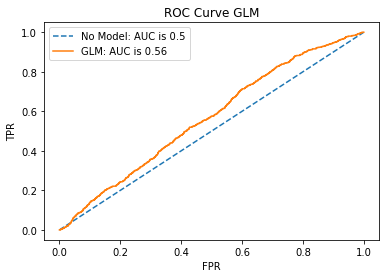

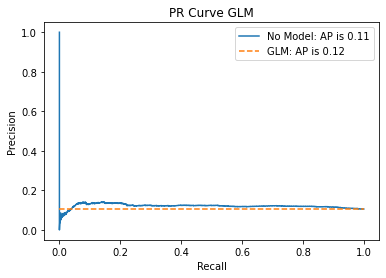

In [90]:
# selected parameters test set

col = x_test.columns[rfe.support_]
x_test_sm = sm.add_constant(x_test[col])

y_test_pred2 = res2.predict(x_test_sm)
y_test_pred_final2 = pd.DataFrame({'EZ':y_test.values, 'EZ_Prob':y_test_pred})
y_test_pred_final2['NodeID'] = y_test.index

# find best probability
accuracy2 = []
for i in np.arange(0,1,0.0001):
    y_test_pred_final2['predicted'] = y_test_pred_final2.EZ_Prob.map(lambda x: 1 if x > i else 0)
    accuracy2.append(metrics.accuracy_score(y_test_pred_final2.EZ, y_test_pred_final2.predicted))
best_pro_index2 = accuracy2.index(max(accuracy2))

# Creating new column 'predicted' 
y_test_pred_final2['predicted'] = y_test_pred_final2.EZ_Prob.map(lambda x: 1 if x > (best_pro_index2/10000) else 0)

# print('Accuracy on the test set is',metrics.accuracy_score(y_test_pred_final.EZ, y_test_pred_final.predicted))

# ROC Curve and auc value for the test set

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred2)
roc_auc = metrics.auc(fpr,tpr)
# print('AUC of the test set is', roc_auc)

# pr curve and average
precision,recall,threshold = metrics.precision_recall_curve(y_test, y_test_pred2)
Ave_Prec = average_precision_score(y_test, y_test_pred2, average='macro', pos_label=1, sample_weight=None)
# print('AP of the test set is', Ave_Prec)

# dummy classifier for pr curve 
y_pred_dummy2 = np.random.randint(0, 2, len(y_test))
pr_dummy2 = len(y_test[y_test==1]) / len(y_test)
# print('AP for the dummy classifier is',pr_dummy)

# plot ROC
plt.figure()
plt.plot([0,1],[0,1],linestyle = '--')
plt.plot(fpr,tpr)
plt.legend(['No Model: AUC is 0.5','GLM: AUC is {}'.format('%0.2f'%roc_auc)], loc = 'best')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve GLM')

# PR Curve and AP value for the test set
plt.figure()
plt.plot(recall,precision)
plt.plot([0, 1], [pr_dummy2, pr_dummy2], linestyle = '--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['No Model: AP is {}'.format('%0.2f'%pr_dummy2),'GLM: AP is {}'.format('%0.2f'%Ave_Prec)], loc = 'best')
plt.title('PR Curve GLM')